# A small model on degrees of separation

A small model inspired by this tweet by Andrew Trask: https://twitter.com/iamtrask/status/1233815704543080448

    So most folks have heard of 5/6-degrees of separation
    In theory, every two people on earth are connected by roughly 5-6 relationships
    But that's for a *whole* life of interactions!!!
    I wonder what it is for 2 days of interactions, or 7 days of interactions? 
    Does anyone know?

Below, I'm trying to model this situation explicitly, with 3 different scenarios of how a kid may be integrated in the society.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import time

In [29]:
n_people = 300
min_degree = 5

def make_net(n=10,mindeg=1):
    """Preferential attachment algorithm."""
    if n<2: return ('Cannot do less than 3 nodes.')
    net = {0:[1], 1:[0]}
    ends = [0,1]
    for i in range(2,n):
        j = rnd.choice(ends)
        net[i] = [j]
        net[j].append(i)
        ends = ends + [i,j]
    for i in range(n): # Guaranteed degree
        if len(net[i])<mindeg:
            for k in range(mindeg-len(net[i])):
                j = rnd.choice(ends)
                if j not in net[i]: net[i].append(j)
                if i not in net[j]: net[j].append(i)
    return net
        
# Make net
net = make_net(n_people,min_degree)
if n_people<10:
    print(net)

In [30]:
# The distribution of degrees of separation

def bfs(net,deg,root,target):
    """Do breadth-first search to find shortest connection from i to j."""
    if root==target: return
    q = net[root].copy()
    visited = [0]*len(net)
    visited[root] = 1
    depth = 0
    while len(q)>0:
        depth += 1
        can_take_shortcut = True      # Whether we reached the area of known distances
        min_known_distance = n_people # Functionally, +Inf
        for k in range(len(q)):       # One layer
            i = q.pop(0)              # Queue, not stack, so pop from 0
            if deg[root,i] == 0:
                deg[root,i] = depth
                deg[i,root] = depth
            if deg[i,target] == 0:
                can_take_shortcut = False # This layer is not fully known
            else:
                min_known_distance = min(min_known_distance,deg[i,target])
            visited[i] = 1
            if i==target: return            
            q = q+[j for j in net[i] if not visited[j]]
        if can_take_shortcut: # We reached a layer where all further connections are known
            deg[root,target] = min_known_distance+depth
            deg[target,root] = deg[root,target]
            return

def degrees(net,verbose=True):
    """Return a matrix of degrees of separation."""
    n = len(net)
    deg = np.zeros((n,n))
    for i in range(1,len(deg)):
        if verbose:
            print('.',end='')
            if i % 100 == 0: print()
        for j in range(i):
            if deg[i,j]==0:
                bfs(net,deg,i,j) # Breadth-first-search. Probably not too efficient, but oh well.
    return deg

# Calculate
tic = time.time()
deg = degrees(net)
print(f"\nDone. Time passed: {time.time()-tic:3.1f} s") # Default: 3.4s for 200 nodes
if n_people<10:
    print(deg)

....................................................................................................
....................................................................................................
...................................................................................................
Done. Time passed: 2.2 s


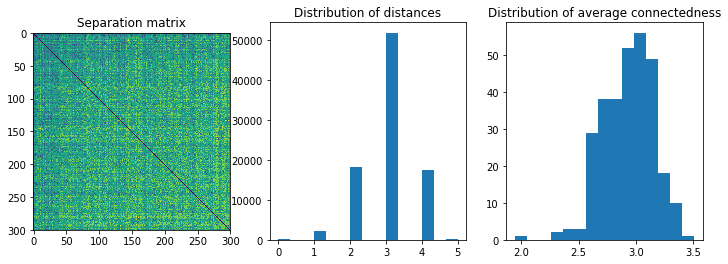

In [31]:
# Visualize
plt.figure(figsize=(12,4))
plt.subplot(131);
plt.imshow(deg);
plt.title('Separation matrix')

plt.subplot(132);
plt.hist(deg.flatten(), bins=15);
plt.title('Distribution of distances');

plt.subplot(133);
plt.hist(np.mean(deg,axis=0), bins=15);
plt.title('Distribution of average connectedness');

Now let's model ways in which a child may be introduced to a society. I can think of three basic approaches here:

1. Patriarchal society: the kid only gets to know their parent's friends.
2. Dystopia: the kid is raised by the state and gets to know people randomly
3. Exploration (arguably, most realistic one): at each point this kid randomly gets to know on of the friends of their existing friends. Kinda like percolation or annealment.

To keep modeling simpler, at each step I will place the kid at node 0 (assumping that the previous inhabitant of node 0 had passed), but the parent will be selected at random.

How much of the connection matrix has to be recalculated? The first time each kid is born, one has to recalculate the entire matrix, to eliminate the heritage of the deceased node (number 0). After that, as we are adding connections one by one, it is probably enough to zero connections from 0 to every other node, and from every other node to 0.

Literally adding people to the graph might seem more efficient (we'd only had ot recalculate connections from this new node), but without full update, the deg matrix would gradually diverge from the true matrix (as new "kid" nodes would also connect previously unconnected people, but without recalculating the entire matrix we would have never see the effect of it). So to be true to the spirit, we'd had to recalculate the matrix anyways. Which means that the speed of the calculation woudl have been roughly the same.

Mean degree: 7
Patriarchal
..................................................
Dystopian
..................................................
Exploration
..................................................


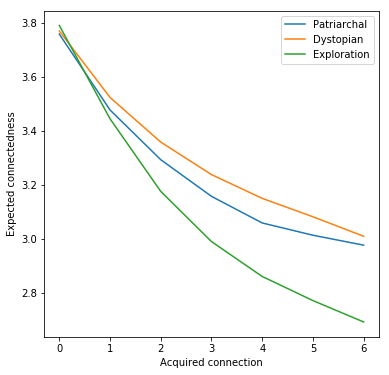

In [34]:
n_trials = 50
mean_deg = int(np.ceil(np.mean([len(v) for k,v in net.items()])))
print('Mean degree:',mean_deg)

def kill(net,i):
    """Remove this individual (from the graph only; doesn't change the degrees matrix)."""
    for j in range(len(net)):
        if j!=i:
            if i in net[j]:
                net[j].remove(i)
        net[i] = []
        
plt.figure(figsize=(6,6));
plt.xlabel('Acquired connection');
plt.ylabel('Expected connectedness');

# Destiny of a child:
for world in ['Patriarchal','Dystopian','Exploration']:
    print(world)
    history = np.zeros((mean_deg,n_trials))
    for i_trial in range(n_trials):
        print('.',end='')
        kill(net,0) # Remove this individual from the graph
        parent = rnd.randint(0,n_people-1)
        pool = net[parent].copy()   # Potential future friends: for now, parent's friends
        count = 0
        while len(pool)>0 and count<mean_deg: # Let this kid aquire at most average number of connections
            new_con = rnd.choice(pool)
            pool.remove(new_con)
            net[new_con].append(0)
            net[0].append(new_con)
            if count==0: # First run, recalculate entire matrix
                deg = degrees(net,verbose=False) # Erase the heritage of the removed node
            else: # One connectionwas added, it's enough to recalculate kid's connections
                deg[0,:] = 0
                deg[:,0] = 0
                for j in range(1,len(net)):
                    bfs(net,deg,0,j)
            history[count,i_trial] = np.mean(deg[0,:])
            
            if world=='Dystopian':
                pool = [rnd.randint(0,n_people-1)] # Next random person
            if world=='Exploration':
                pool = pool + [t for t in net[j] if t not in pool and t not in net[0]]
                # Include all connections of this new friend
            count += 1
        if count<mean_deg:
            history[count:,i_trial] = history[count-1,i_trial]
    print()            
    plt.plot(np.mean(history, axis=1), label=world);

plt.legend(loc='upper right');

**Conclusion**: As expected, an average newborn starts 1 degree of separation further apart, as originally they are only connected to their parent. Then they gradually "relax" to the mean. 

The dynamics of this relaxation doesn't depend that much on the way they are introduced to the society: either way, they sample from a power-skewed distribution of degrees. There are however some differences.

"Dystopian" approach leads to least connected children, as it samples people randomly, and thus draws many people who are poorly connected. "Patriarchal" approach is better, as the parent is more likely to be connected to well-connected people (in accordance with the famous paradox that your friends have more friends than you do). "Exploration", however, is the best one, as it further amplifies this effect (not only your parents are more likely to be connected to influencers, but also always picking a friend out of friends of your friends, you are even further likely to hit an influencer).